In [1]:
%load_ext autoreload
%autoreload 2

# Wake from Gaussian

In [2]:
from csr3d.csr1d import csr1d_steady_state_kick_calc

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import scipy.constants
from scipy.interpolate import RegularGridInterpolator
mec2 = scipy.constants.value("electron mass energy equivalent in MeV") * 1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value("classical electron radius")

# Parameters

In [5]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_x = 10e-6
sigma_y = 10e-6 
sigma_z = 10e-6 

rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2

# Characteristic wake in eV/m from Chris's paper
#W0 = Nb* r_e * mec2 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

# Density

In [6]:
xmax = sigma_x*5
xmin = -xmax
xptp = xmax-xmin

ymax = sigma_y*5
ymin = -ymax
yptp = ymax-ymin

zmax = sigma_z*5
zmin = -zmax
zptp = zmax-zmin

nx = 256
ny = 256
nz = 256


dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

deltas = (dx, dy, dz)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

In [7]:
from csr3d.dist import gauss, lambda_gauss3, lambda_gauss3_prime

In [8]:
density = lambda_gauss3(X, Y, Z, sigma_x=sigma_x, sigma_y=sigma_y, sigma_z=sigma_z)
norm = np.sum(density) * dx * dy *dz
density /= norm
density_prime = lambda_gauss3_prime(X, Y, Z, sigma_x=sigma_x, sigma_y=sigma_y, sigma_z=sigma_z) /norm

In [9]:
# Check that this is 1
np.sum(density)* dx * dy *dz

0.9999999999999996

# Green function

In [10]:
from csr3d.wake import green_mesh

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
%%time
Gs = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='s')

CPU times: user 23.4 s, sys: 1.48 s, total: 24.8 s
Wall time: 4.54 s


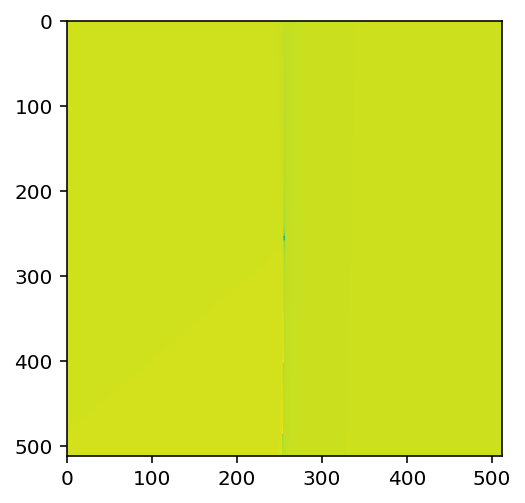

In [12]:
plt.imshow(Gs[:,ny-1,:])

# Convolution

In [13]:
from csr3d.convolution import fftconvolve3

In [14]:
%%time
Ws = fftconvolve3(density_prime, Gs)[0]
Ws.shape

CPU times: user 10.7 s, sys: 1.55 s, total: 12.3 s
Wall time: 12.4 s


(256, 256, 256)

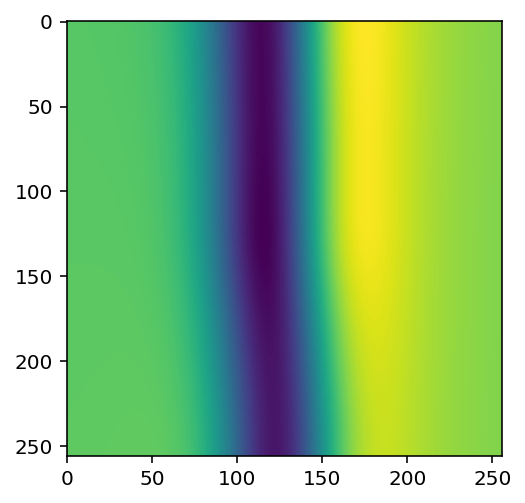

In [15]:
plt.imshow(Ws[:,ny//2,:])

# Wake plot

$\Psi_s$

Compare with Fig. 5 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [16]:
# Conversion factor for 1/m^2
factor = (beta2 / (rho)) * (dx * dy * dz)
factor

6.030838817649323e-20

In [17]:
# Quickly get nearest indices for +/- sigma_x
ix_pos = np.abs((xvec/sigma_x) - (1)).argmin()
ix_neg = np.abs((xvec/sigma_x) - (-1)).argmin()
(xvec/sigma_x)[ix_pos], (xvec/sigma_x)[ix_neg]

(1.0000000000000004, -0.9999999999999998)

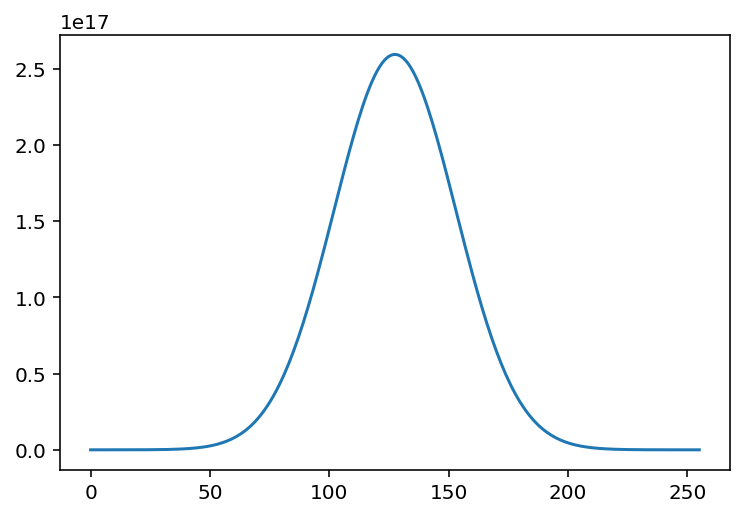

In [18]:
plt.plot(np.sum(np.sum(density, axis=0), axis=0))

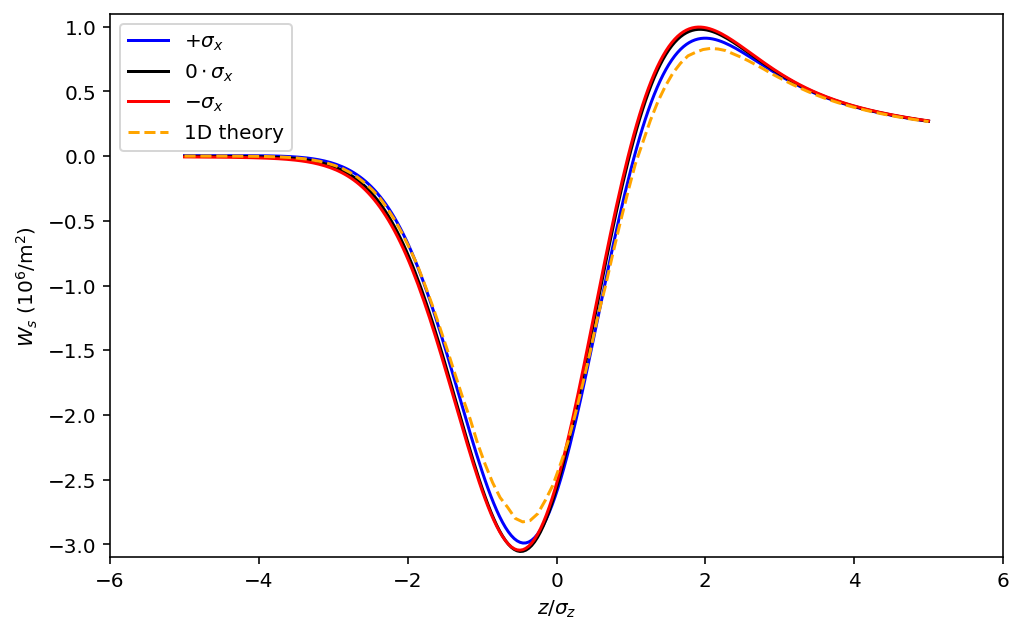

In [19]:
# 1D CSR steady state wake
zvec1 = np.linspace(zmin, zmax, 10*nz)
density1 = gauss(zvec1, sigma=sigma_z)
SS = csr1d_steady_state_kick_calc(zvec1, density1, normalized_units=True)

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
ax.set_ylim(-3.1,1.1)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_s$ ($10^6$/m$^2)$')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
  
ax.plot(zvec/sigma_z, Ws[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Ws[nx//2, ny//2,  :]*factor/1e6, color='black', label=r'$0\cdot\sigma_x$')  
ax.plot(zvec/sigma_z, Ws[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red') 
ax.plot(SS['zvec']/sigma_z, SS['wake']/1e6, color='orange', linestyle='--', label='1D theory')
ax.legend()

# psi_xhat

$\hat{\Psi}_x = \Psi_x - \Psi_\phi$ from Eq. 24

Compare with Fig. 6 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [20]:
%%time
Gxhat = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='xhat')
Gxhat.min()

CPU times: user 1min 48s, sys: 3.35 s, total: 1min 51s
Wall time: 18.6 s


-6.798244327415461

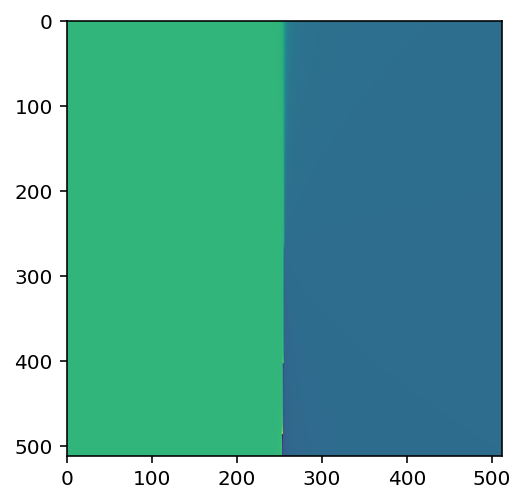

In [21]:
plt.imshow(Gxhat[:,ny-1,:])

In [22]:
%%time
Wxhat = fftconvolve3(density_prime, Gxhat)[0]
Wxhat.shape

CPU times: user 12.2 s, sys: 3.82 s, total: 16 s
Wall time: 17.1 s


(256, 256, 256)

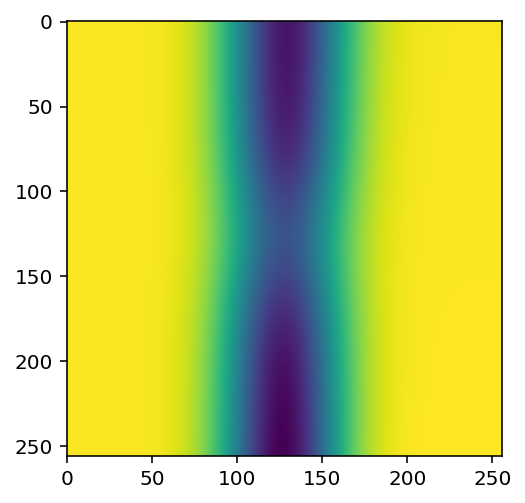

In [23]:
plt.imshow(Wxhat[:,ny//2,:])

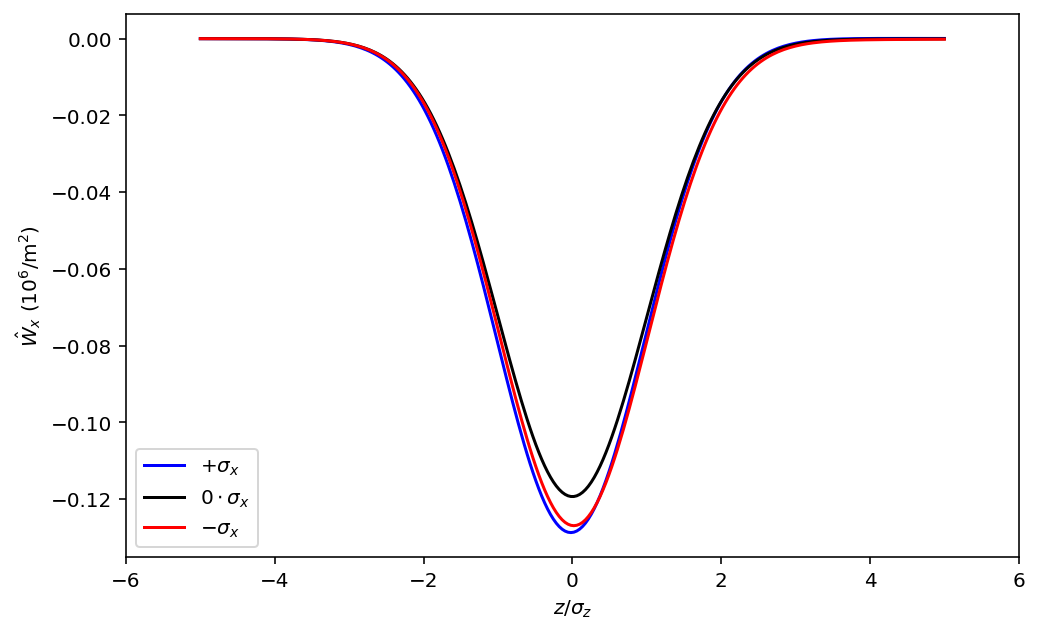

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$\hat{W}_x$ ($10^6$/m$^2$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wxhat[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wxhat[nx//2, ny//2, : ]*factor/1e6, color='black',label=r'$0\cdot\sigma_x$') 
ax.plot(zvec/sigma_z, Wxhat[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red')  
  

ax.legend()

# psi_x

$\Psi_x$ from Eq. 24

In [25]:
%%time
Gx = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='x')
Gx.min()

CPU times: user 1min 56s, sys: 8.76 s, total: 2min 4s
Wall time: 28.4 s


-13.74377622313018

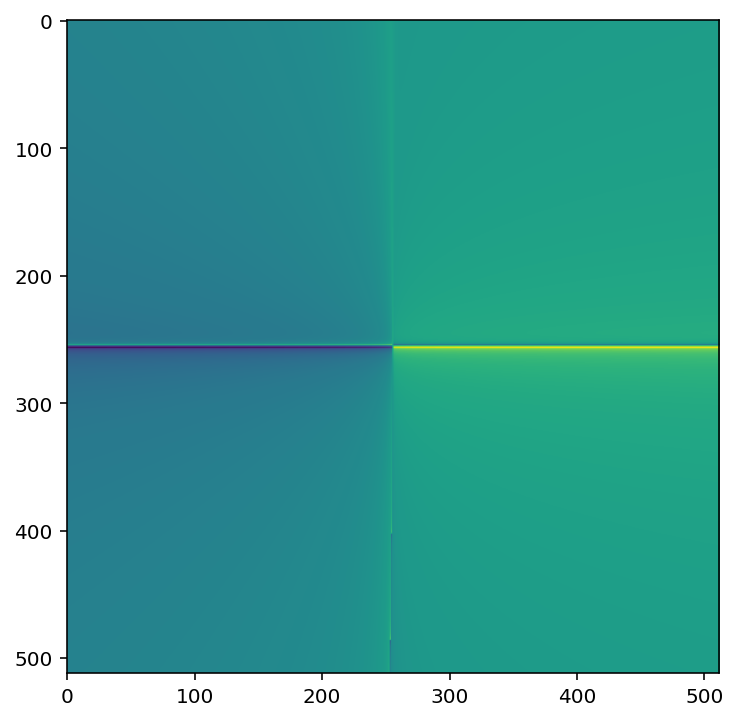

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(Gx[:,ny-1,:])

In [27]:
%%time
Wx = fftconvolve3(density_prime, Gx)[0]
Wx.shape

CPU times: user 12.6 s, sys: 3.72 s, total: 16.3 s
Wall time: 18.3 s


(256, 256, 256)

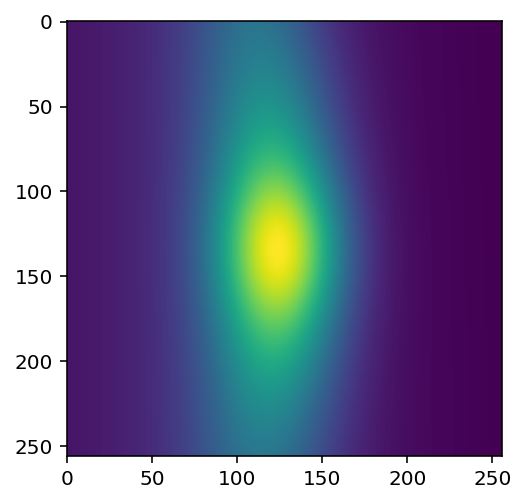

In [28]:
plt.imshow(Wx[:,ny//2,:])

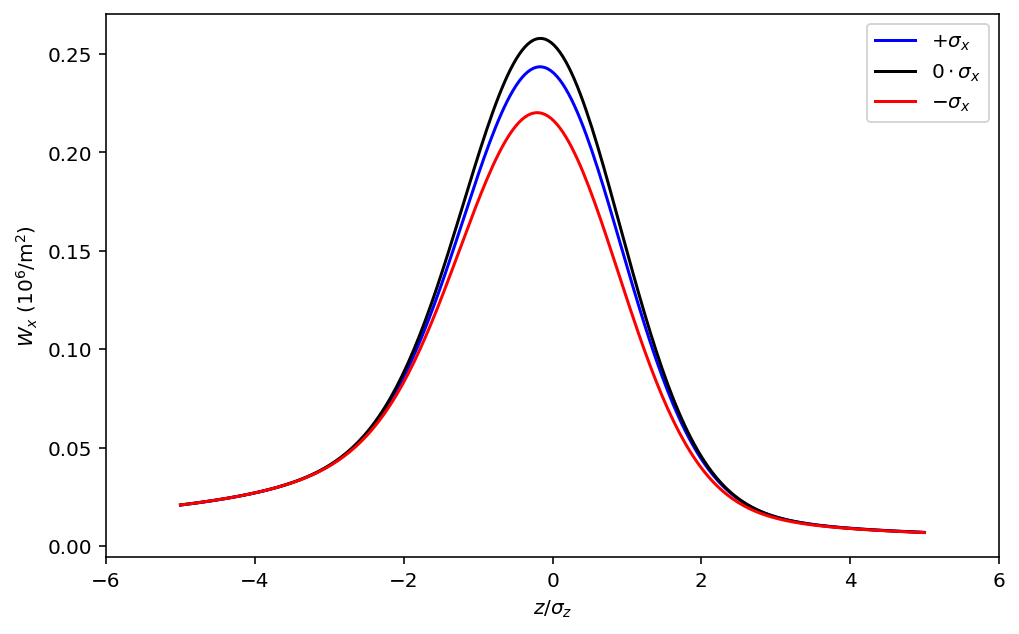

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_x$ ($10^6$/m$^2$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wx[ix_pos, ny//2, :]*factor/1e6, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wx[nx//2, ny//2, :] *factor/1e6,  label=r'$0\cdot\sigma_x$', color='black')   
ax.plot(zvec/sigma_z, Wx[ix_neg, ny//2, :]*factor/1e6, label=r'$-\sigma_x$', color='red')  
ax.legend()

# psi_phi

In [30]:
%%time
Gphi = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='phi')
Gphi.min()

CPU times: user 1min 7s, sys: 6.11 s, total: 1min 13s
Wall time: 14.9 s


-6.234436663575099

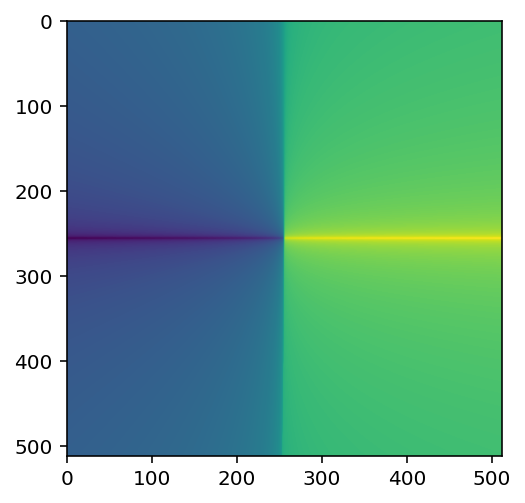

In [31]:
plt.imshow(Gphi[:,ny-1,:])

In [32]:
%%time
Wphi = fftconvolve3(density_prime, Gphi)[0]
Wphi.shape

CPU times: user 13.6 s, sys: 4.95 s, total: 18.5 s
Wall time: 19.9 s


(256, 256, 256)

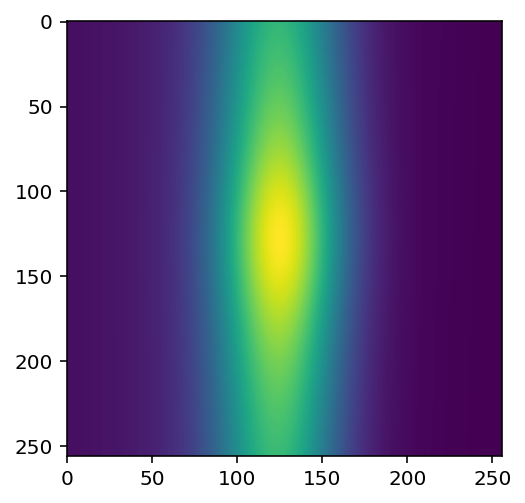

In [33]:
plt.imshow(Wphi[:,ny//2,:])

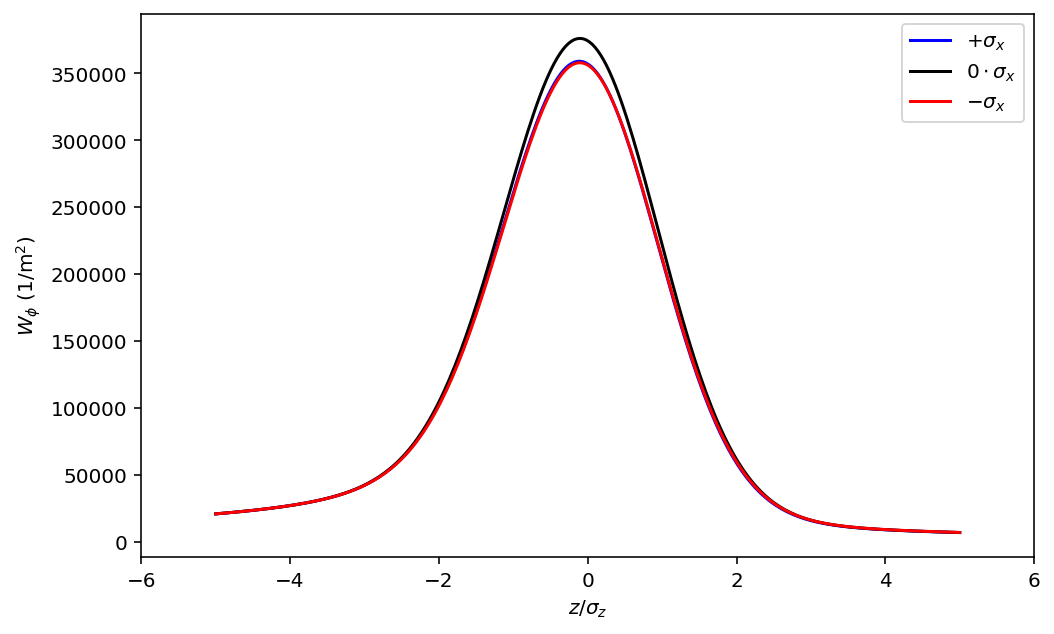

In [34]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_\phi$ (1/m$^{2}$)')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wphi[ix_pos, ny//2, :]*factor, label=r'$+\sigma_x$', color='blue')  
ax.plot(zvec/sigma_z, Wphi[nx//2, ny//2, :]*factor, label=r'$0\cdot\sigma_x$', color='black')      
ax.plot(zvec/sigma_z, Wphi[ix_neg, ny//2, :]*factor, label=r'$-\sigma_x$', color='red')  
ax.legend()

# psi_y

Compare with Fig. 8 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402



In [35]:
%%time
Gy = green_mesh(density.shape, deltas, rho=rho, gamma=gamma, component='y')

CPU times: user 1min 57s, sys: 6.24 s, total: 2min 3s
Wall time: 21.6 s


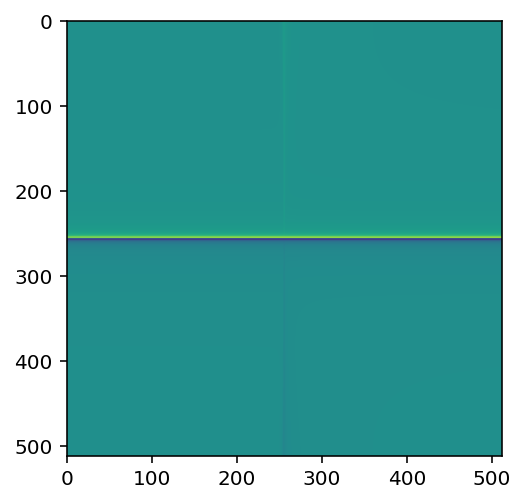

In [36]:
plt.imshow(Gy[nx-1,:,:])

In [37]:
%%time
Wy = fftconvolve3(density_prime, Gy)[0]
Wy.shape

CPU times: user 11.8 s, sys: 3.15 s, total: 14.9 s
Wall time: 15.4 s


(256, 256, 256)

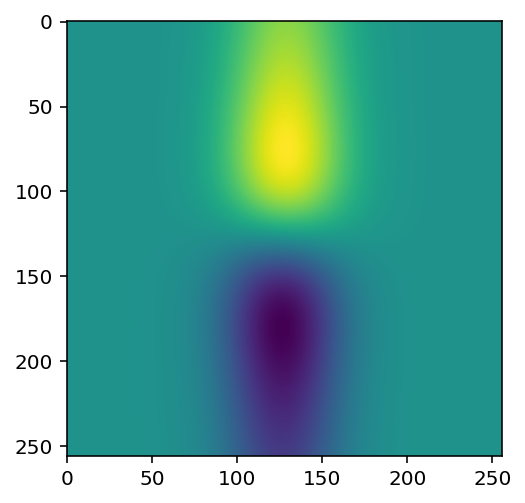

In [38]:
plt.imshow(Wy[:,ny//2,:])

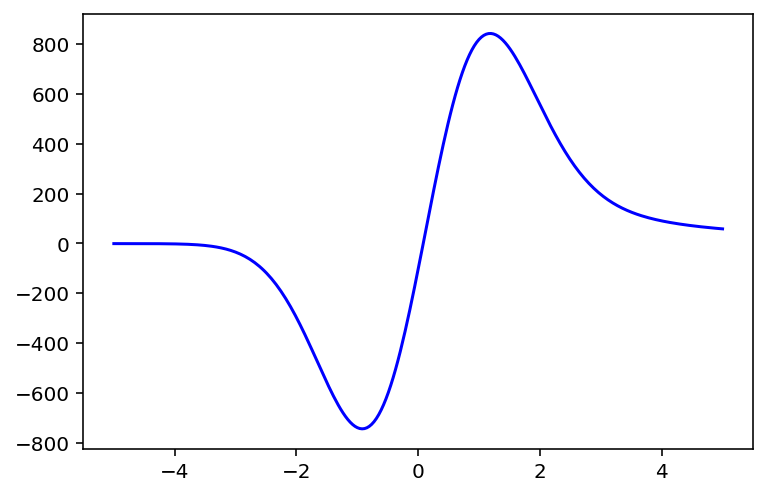

In [39]:

iy_pos = np.abs((yvec/sigma_y) - (1)).argmin()

plt.plot(zvec/sigma_z, Wy[nx//2-1, iy_pos, :]*factor, color='blue') 

In [40]:
(yvec/sigma_y)[iy_pos]

1.0000000000000004

In [41]:
(xvec/sigma_x)[nx//2-1]

-0.019607843137254447

Text(0, 0.5, '$W_y (m^{-2})$')

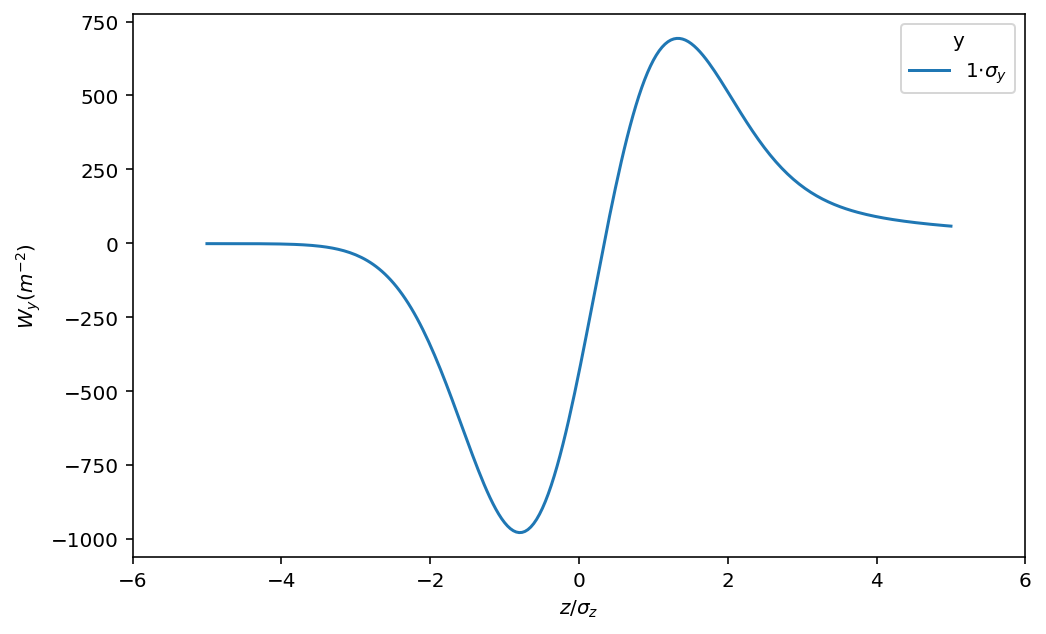

In [42]:
# Make interpolator
Wy_interp = RegularGridInterpolator([xvec, yvec, zvec], Wy)


fig, ax = plt.subplots(figsize=(8,5))
for yi in [1]: #np.arange(-1,1.5,0.5):
    pts = np.array([[0, yi*sigma_y, z] for z in zvec])
    vals = Wy_interp(pts)
    ax.plot(zvec/sigma_z, vals*factor, label=f'{yi}'+r'$\cdot\sigma_y$')
ax.legend(title='y')

ax.set_xlim(-6,6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_y (m^{-2})$')

# 3D plot

In [43]:
cdata = density.sum(axis=1)
from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(cdata/cdata.max())

X, Z= np.meshgrid(xvec, zvec, indexing="ij")

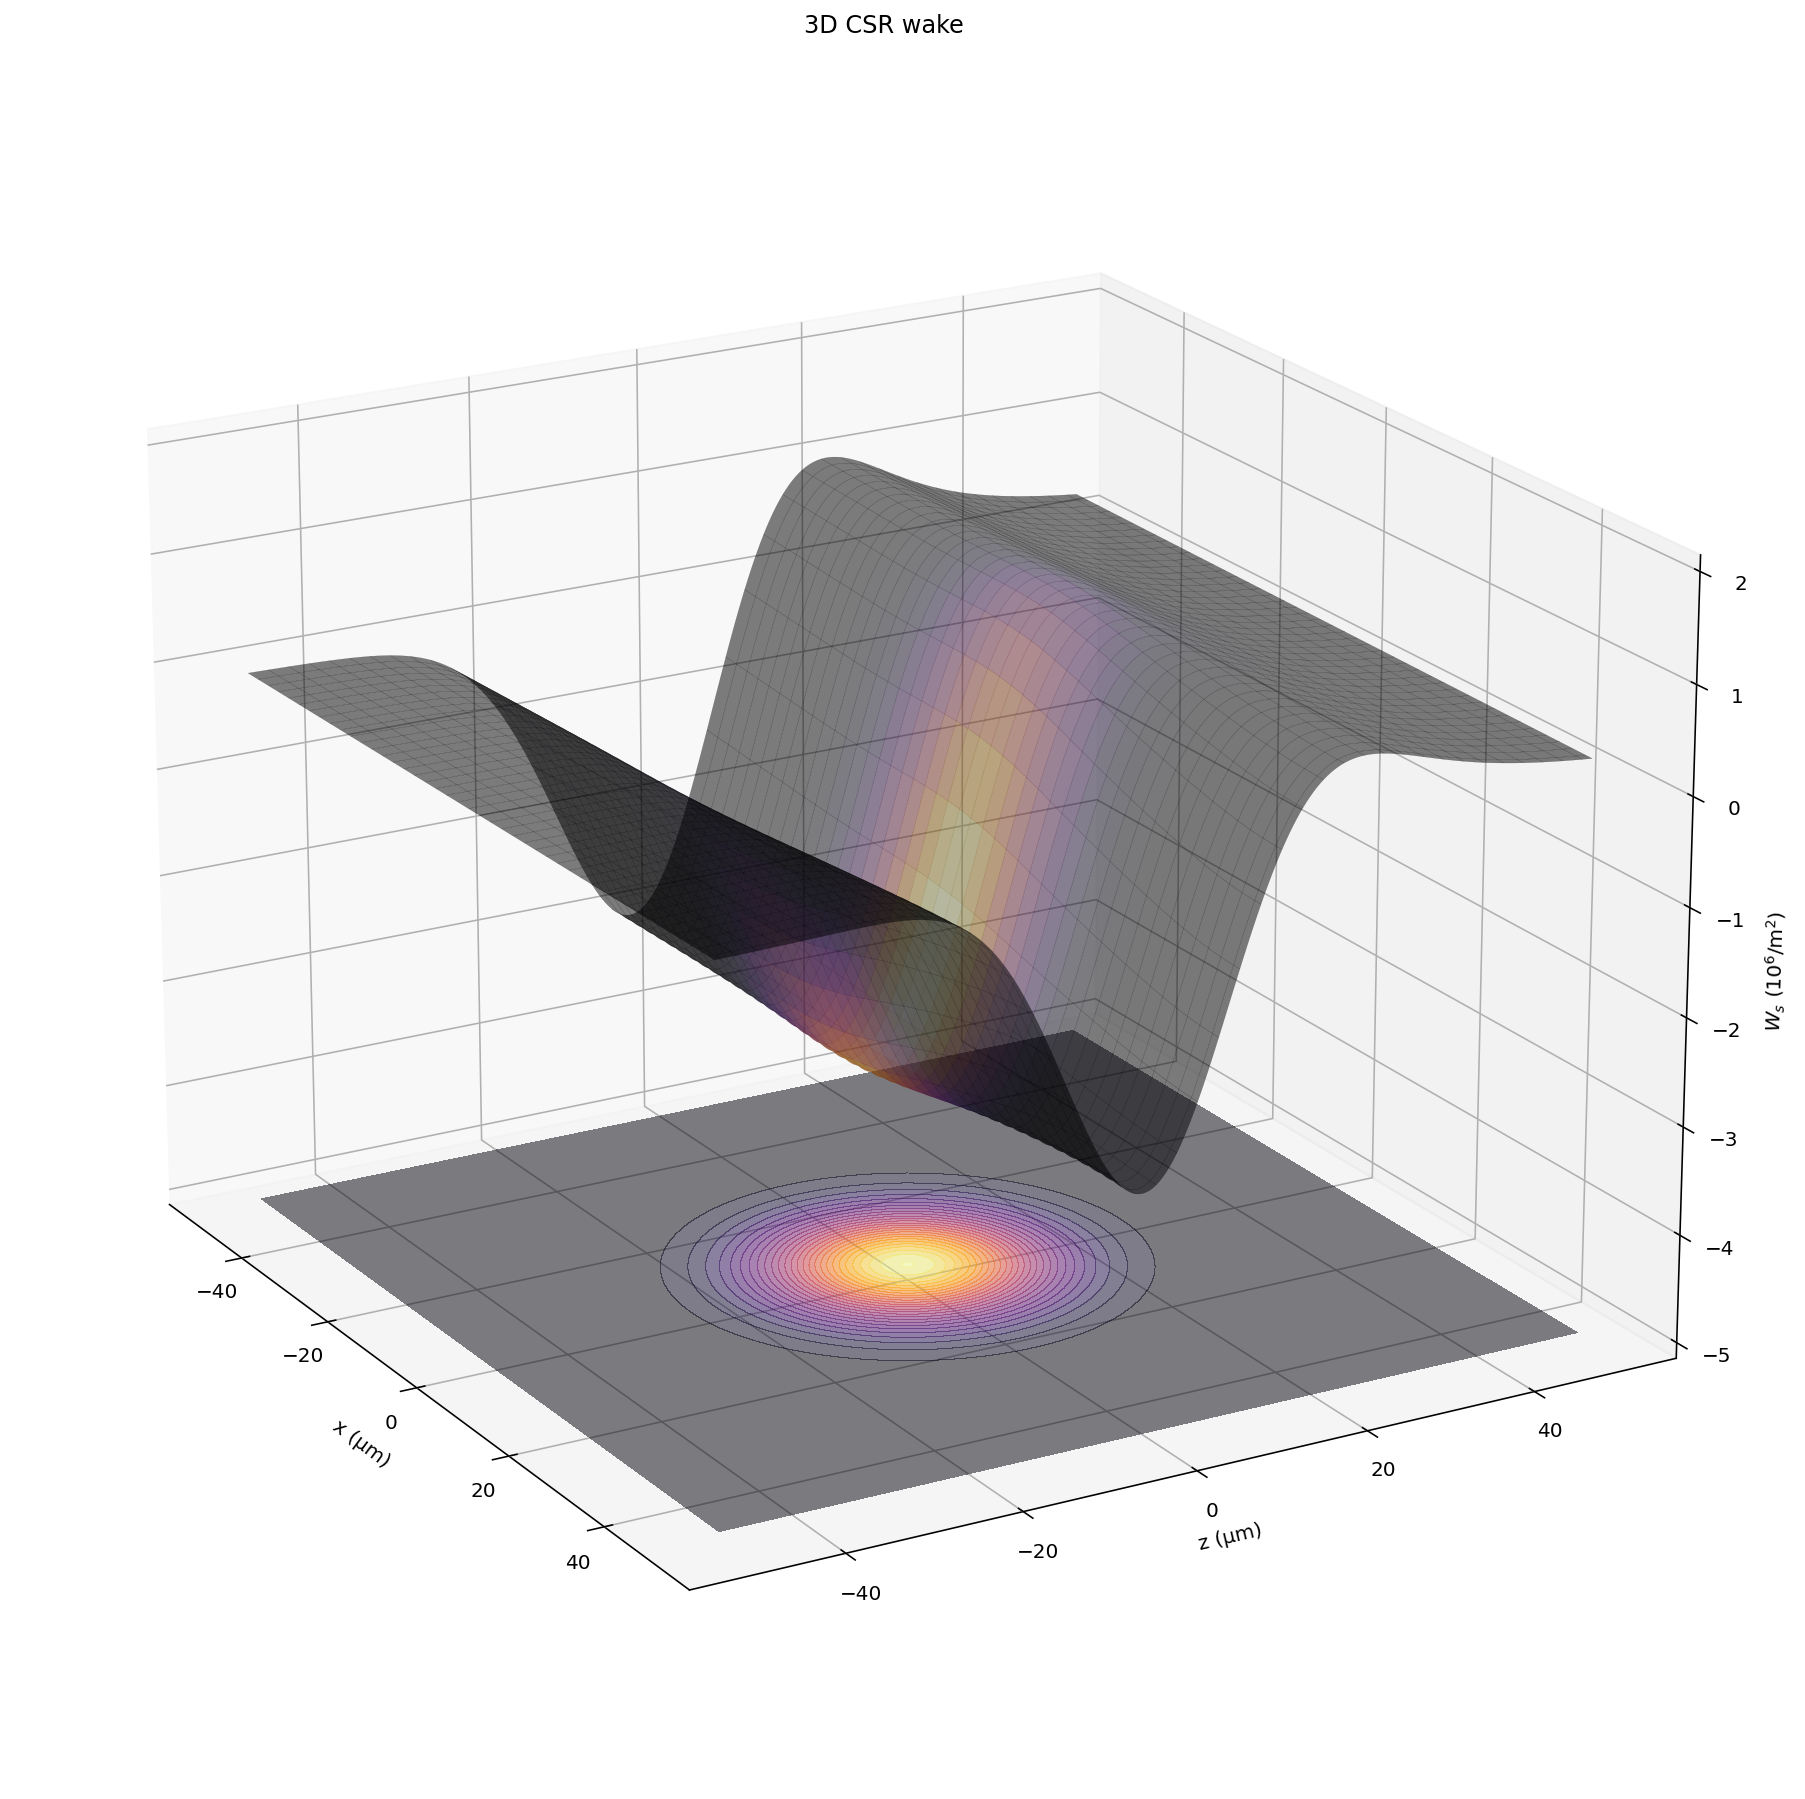

In [44]:
LABEL=r'$W_s~(10^6/$m$^2$)'
PFILE = f'Ws_3d.png'
W = Ws[:,ny//2,:]*factor

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(X/1e-6, Z/1e-6, cdata, 30, zdir='z', offset=-5, 
           extent=[zmin, zmax, xmin, xmax], cmap=cmap, alpha=0.5)
ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(-5, 2)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+60)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

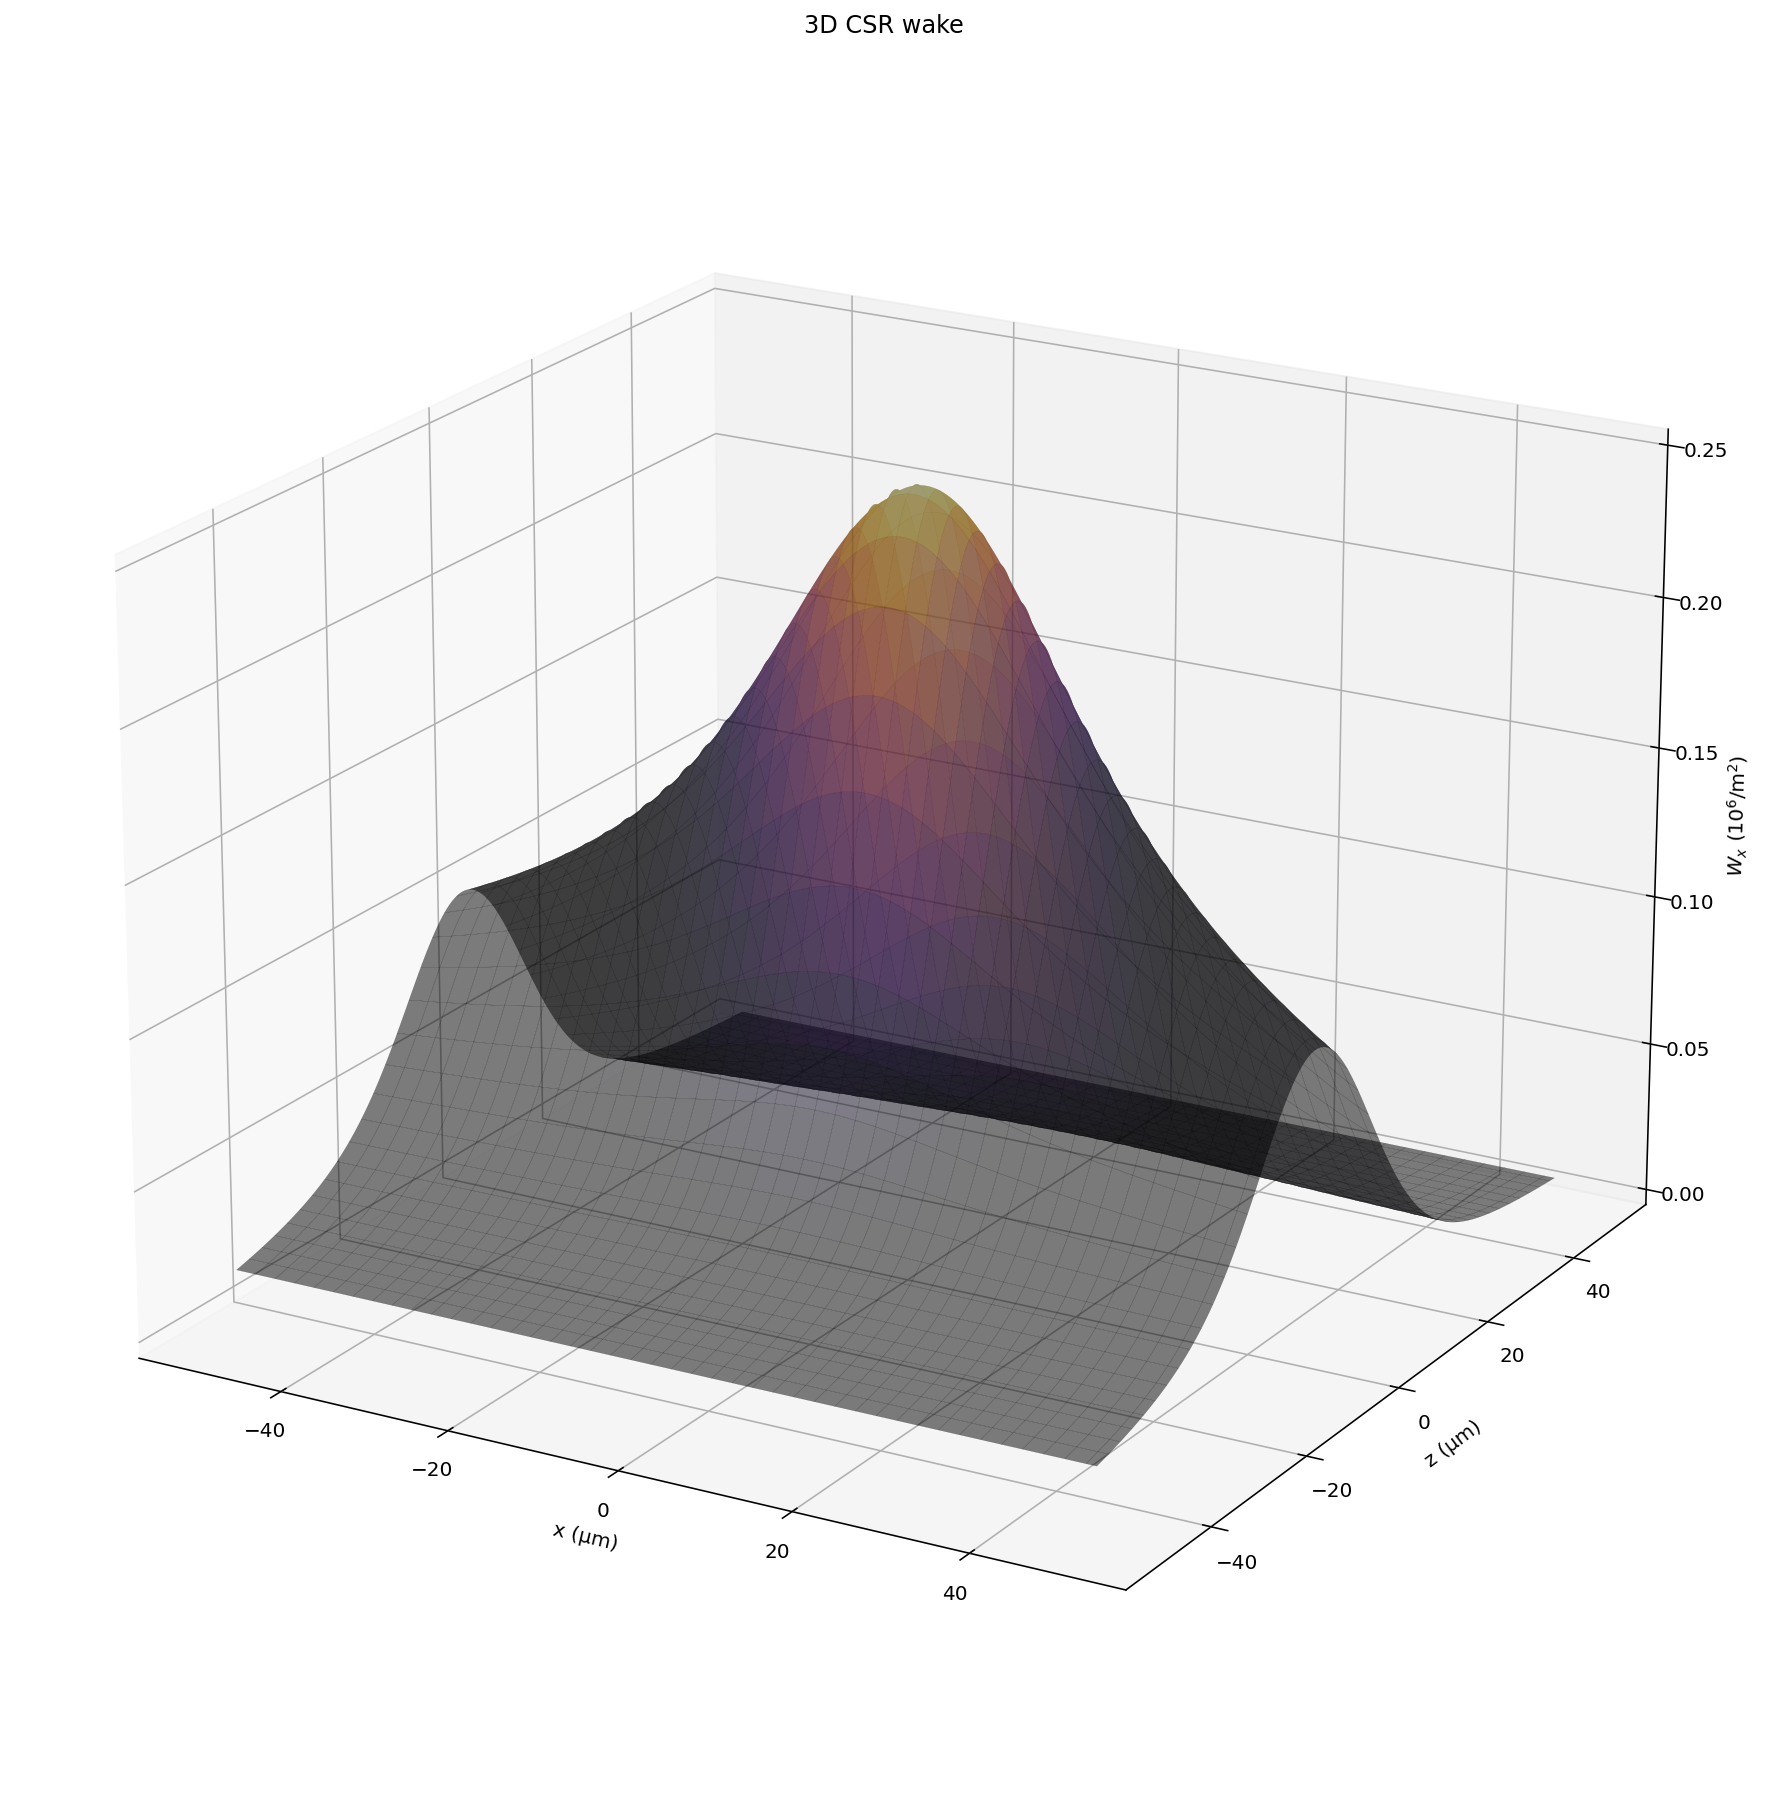

In [45]:
LABEL=r'$W_x~(10^6/$m$^2$)'
PFILE = f'Wx_3d.png'
W = Wx[:,ny//2,:]*factor

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(0, 2.5e5/1e6)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")

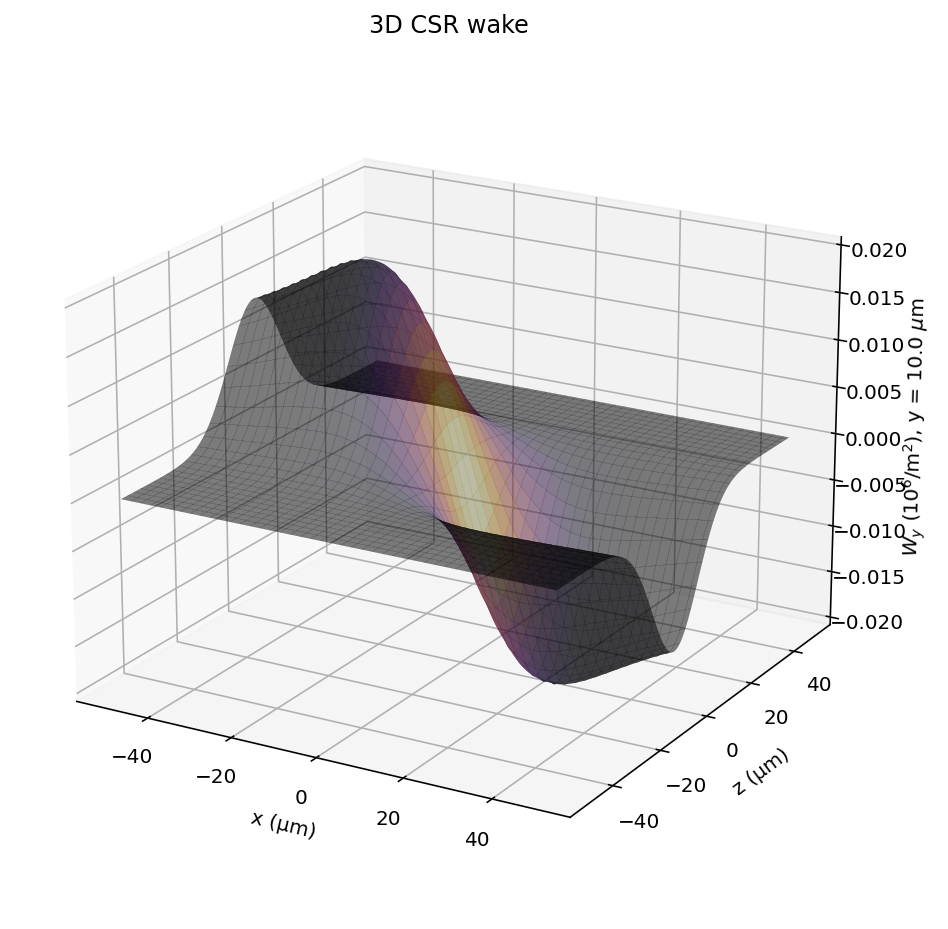

In [46]:
LABEL=rf'$W_y~(10^6/$m$^2$), y = {Y[0,iy_pos,0]/1e-6:0.1f} $\mu$m'
PFILE = f'Wy_3d.png'
W = Wy[:,iy_pos,:]*factor

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e-6, Z/1e-6, W/1e6, alpha=0.5, facecolors=colors, linewidth=.1)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
#ax.contourf(X/1e-6, Z/1e-6, cdata, 10, zdir='z', offset=0, 
 #          extent=[zmin, zmax, xmin, xmax], cmap=cmap)
ax.set_title('3D CSR wake')
ax.set_xlabel('x (µm)')
ax.set_ylabel('z (µm)')
ax.set_zlim(-.02, .02)
ax.zaxis.set_rotate_label(True)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 270+30)
plt.savefig(PFILE, dpi=150, bbox_inches="tight")